In [1]:
from matplotlib import  pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

The dataset was originally from Yeh and Hsu (2018) where the dataset was about market historical of real estate collected from Xindian District, New Taipei City, Taiwan in two years (i.e.; 2012 and 2013). The dataset consists of 414 observations

In [2]:
df = pd.read_excel('../data/Real estate valuation data set.xlsx')
df['X1 transaction date'] = df['X1 transaction date'].map(lambda x: math.floor(x))
df = df.drop(['No','X5 latitude','X6 longitude'],1)
df = df.rename(columns={'X2 house age':'house_age','X3 distance to the nearest MRT station':'MRT_dist',\
                   'X4 number of convenience stores':'stores_no','Y house price of unit area':'price_per_area',
                       'X1 transaction date':'year'})

df.to_csv('house_price.csv',index=None)

In [3]:
df.head()

,year,house_age,MRT_dist,stores_no,price_per_area
0,2012,32.0,84.87882,10,37.9
1,2012,19.5,306.59470,9,42.2
2,2013,13.3,561.98450,5,47.3
3,2013,13.3,561.98450,5,54.8
4,2012,5.0,390.56840,5,43.1


### Split data into 2 years for comparison purpose

In [4]:
df_2012 = df[df['year']==2012].copy()
df_2013 = df[df['year']==2013].copy()

df = df.drop('year',1)

df_2012.to_csv('house_price_2012.csv',index=None)
df_2013.to_csv('house_price_2013.csv',index=None)

In [236]:
df_2012.shape, df_2013.shape

((126, 5), (288, 5))

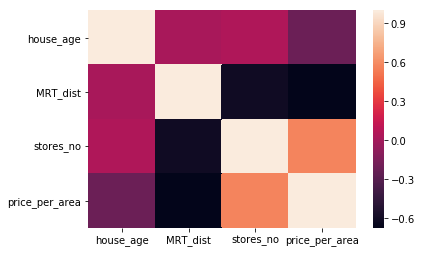

In [234]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

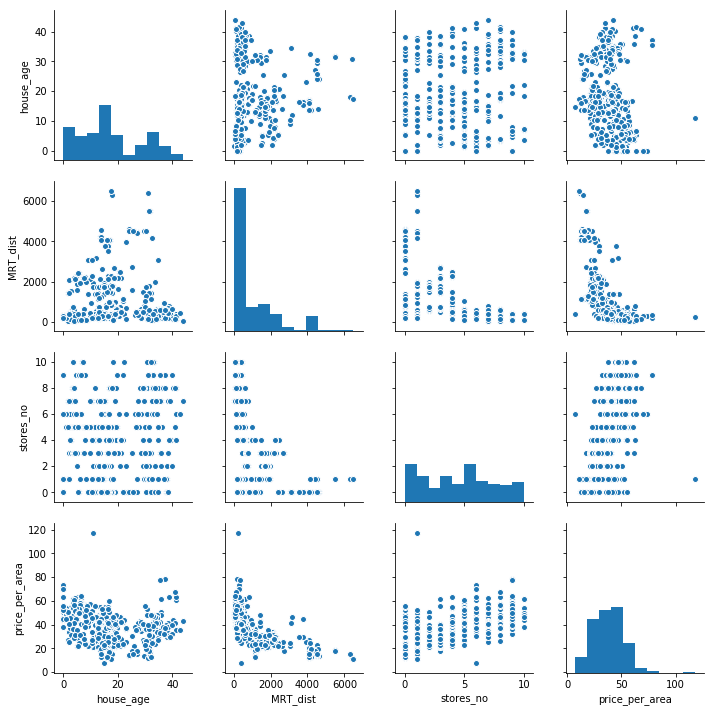

In [89]:
sns.pairplot(df)

In [ ]:
df = df[df['price_per_area']<100]

## Linear Regression
Linear regression is performed on the dataset to predict house price per area, y.

$$ y = β_0  + β_1 x_1  + β_2 x_2  + β_3 x_3  $$

Where x_1 = house age, x_2= distance to MRT, x_3= Number of convenience stores nearby

### Fit Linear Regression using sklearn

In [94]:
from sklearn.linear_model import LinearRegression

sklr=LinearRegression()
sklr.fit(df[[i for i in df.columns if i not in ['price_per_area']]],df['price_per_area'])
sklr.coef_

array([-0.25285583, -0.00537913,  1.29744248])

In [95]:
['{} * {}'.format(round(i,5),j) for i,j in zip(sklr.coef_, df[[i for i in df.columns if i not in ['kWh','kWh_scaled']]])]\
+[round(sklr.intercept_,5)]

['-0.25286 * house_age',
 '-0.00538 * MRT_dist',
 '1.29744 * stores_no',
 42.97729]

In [96]:
predicted = sklr.predict(df[[i for i in df.columns if i not in ['price_per_area']]])
squared_diff =(df['price_per_area'] - predicted).values**2
np.mean(squared_diff)

84.76070642266242

### Linear Regression using PYMC3

In [113]:
df.columns

Index(['house_age', 'MRT_dist', 'stores_no', 'price_per_area'], dtype='object')

In [114]:
y=df['price_per_area'].values
x_1 = df['house_age'].values
x_2 = df['MRT_dist'].values
x_3 = df['stores_no'].values

In [148]:
import pymc3 as pm

with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    c = pm.Normal('c', mu=0, sd=100)
    d = pm.Normal('d', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)

    y_est = a*x_1 + b*x_2 + c*x_3  + d 
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    start = pm.find_MAP()

logp = -1,520.5, ||grad|| = 537.06: 100%|█████| 89/89 [00:00<00:00, 935.95it/s] 


In [149]:
start

{'a': array(-0.2453782),
 'b': array(-0.00507932),
 'c': array(1.44122829),
 'd': array(41.74155471),
 'sigma': array(7.82543493),
 'sigma_log__': array(2.05737932)}

In [120]:
with linreg:
    step = pm.Metropolis()
    trace = pm.sample(50000, step, start=start, njob=-1, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [d]
>Metropolis: [c]
>Metropolis: [b]
>Metropolis: [a]
100%|██████████████████████████████████| 50500/50500 [00:50<00:00, 1005.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [121]:
a_mean = np.mean(trace.get_values('a'))
a_std = np.std(trace.get_values('a'))

b_mean = np.mean(trace.get_values('b'))
b_std = np.std(trace.get_values('b'))

c_mean = np.mean(trace.get_values('c'))
c_std = np.std(trace.get_values('c'))

d_mean = np.mean(trace.get_values('d'))
d_std = np.std(trace.get_values('d'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F116AA47B8>,
      dtype=object)

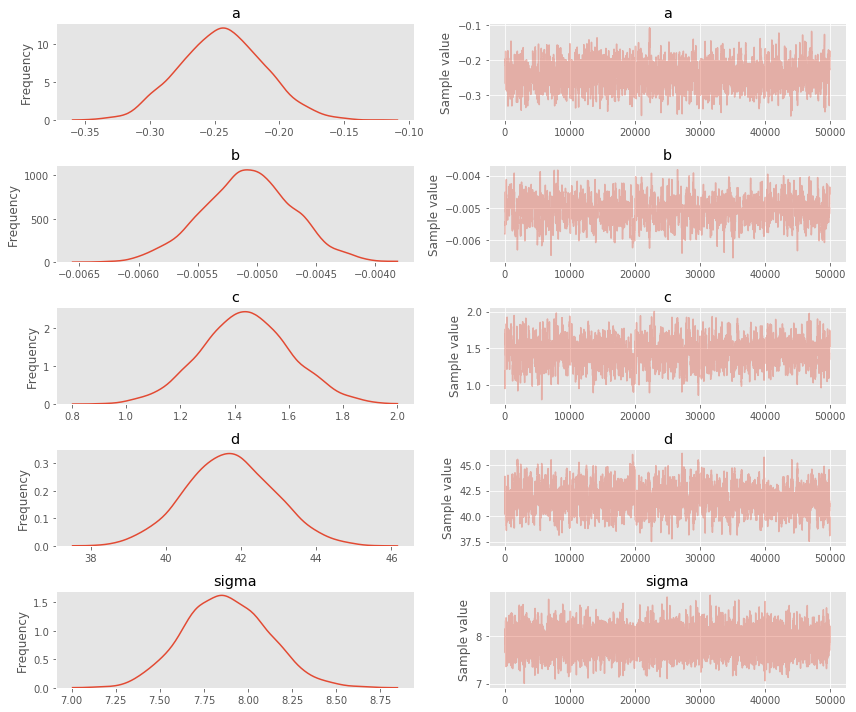

In [122]:
pm.traceplot(trace)

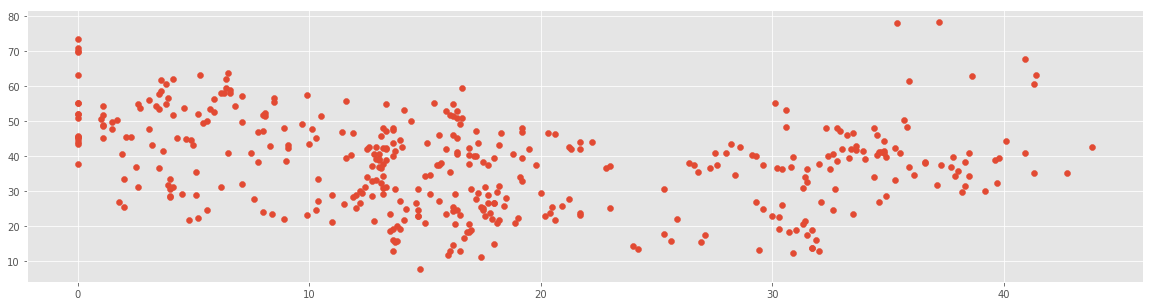

In [138]:
t = trace[49500:]

Text(0.5,1,'House Age')

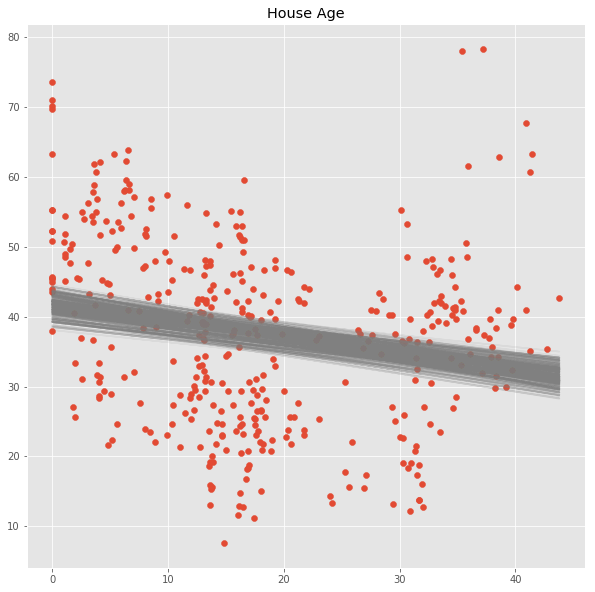

In [140]:
plt.rcParams['figure.figsize'] = [10,10]

plt.scatter(x_1, y)
for a_, b_ in zip(t['a'], t['d']):
    plt.plot(x_1, a_*x_1+b_, c='gray', alpha=0.1)
    
plt.title('House Age')

---
# 2012

In [31]:
y_2012 = df_2012['price_per_area'].values
x_1 = df_2012['house_age'].values
x_2 = df_2012['MRT_dist'].values
x_3 = df_2012['stores_no'].values

In [42]:
import pymc3 as pm

with pm.Model() as linreg_2012:
    a = pm.Normal('beta_1', mu=0, sd=100)
    b = pm.Normal('beta_2', mu=0, sd=100)
    c = pm.Normal('beta_3', mu=0, sd=100)
    d = pm.Normal('beta_0', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=100)

    y_est = a*x_1 + b*x_2 + c*x_3  + d 
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y_2012)

    start_2012 = pm.find_MAP()

logp = -440.67, ||grad|| = 36.436: 100%|█████| 80/80 [00:00<00:00, 1002.72it/s] 


In [43]:
with linreg_2012:
    step = pm.Metropolis()
    trace_2012 = pm.sample(50000, step, start=start_2012, njob=-1, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_0]
>Metropolis: [beta_3]
>Metropolis: [beta_2]
>Metropolis: [beta_1]
100%|███████████████████████████████████| 50500/50500 [00:53<00:00, 935.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [44]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [45]:
start_2012

{'beta_0': array(43.33444686),
 'beta_1': array(-0.40346235),
 'beta_2': array(-0.00530352),
 'beta_3': array(1.30016013),
 'sigma': array(6.44898461),
 'sigma_log__': array(1.86392269)}

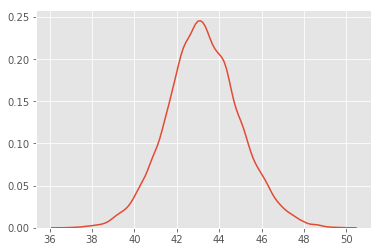

In [47]:
sns.kdeplot(trace_2012.get_values('beta_0'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1078235F8>,
      dtype=object)

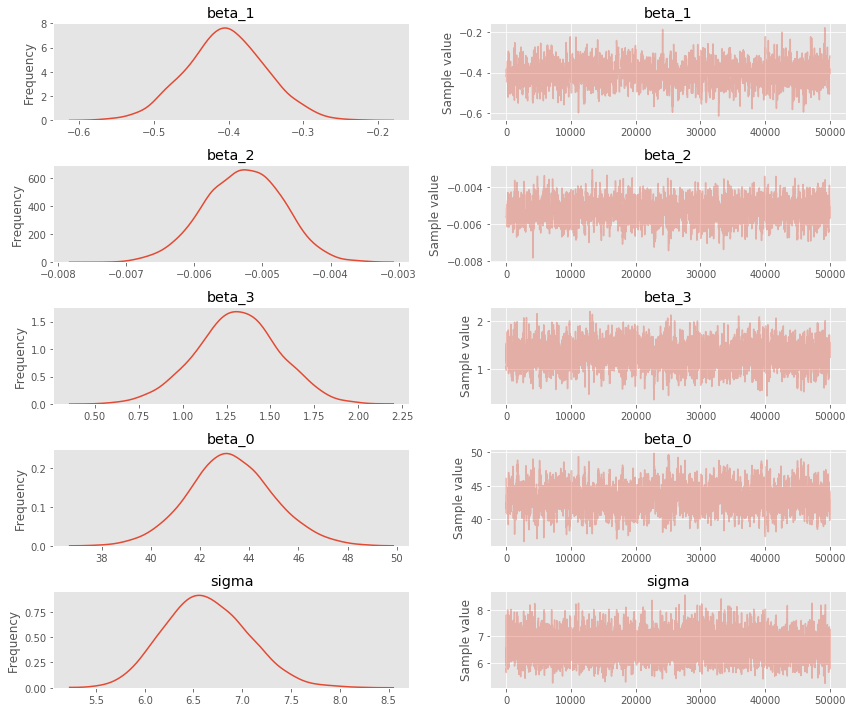

In [48]:
pm.traceplot(trace_2012)

In [50]:
a_mean_2012 = np.mean(trace_2012.get_values('beta_1'))
a_std_2012 = np.std(trace_2012.get_values('beta_1'))

b_mean_2012 = np.mean(trace_2012.get_values('beta_2'))
b_std_2012 = np.std(trace_2012.get_values('beta_2'))

c_mean_2012 = np.mean(trace_2012.get_values('beta_3'))
c_std_2012 = np.std(trace_2012.get_values('beta_3'))

d_mean_2012 = np.mean(trace_2012.get_values('beta_0'))
d_std_2012 = np.std(trace_2012.get_values('beta_0'))

In [56]:
((a_mean_2012 - (1.96*a_std_2012)), (a_mean_2012 + (1.96*a_std_2012)))

(-0.5084263993081027, -0.2989435860796962)

In [55]:
np.std(trace_2012.get_values('sigma'))

0.42638189032366236

# 2013

In [64]:
y_2013 = df_2013['price_per_area'].values
x_1 = df_2013['house_age'].values
x_2 = df_2013['MRT_dist'].values
x_3 = df_2013['stores_no'].values

In [65]:
with pm.Model() as linreg_2013:
    a = pm.Normal('a', mu=a_mean_2012, sd=a_std_2012)
    b = pm.Normal('b', mu=b_mean_2012, sd=b_std_2012)
    c = pm.Normal('c', mu=c_mean_2012, sd=c_std_2012)
    d = pm.Normal('d', mu=d_mean_2012, sd=d_std_2012)
    sigma = pm.HalfNormal('sigma', sd=np.std(trace_2012.get_values('sigma')))

    y_est = a*x_1 + b*x_2 + c*x_3  + d 
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y_2013)

    start_2013 = pm.find_MAP()

logp = -1,248.1, ||grad|| = 79.53: 100%|█████| 70/70 [00:00<00:00, 1002.69it/s]  


In [66]:
start_2013

{'a': array(-0.25952947),
 'b': array(-0.0053022),
 'c': array(1.34152828),
 'd': array(43.72073865),
 'sigma': array(7.11808892),
 'sigma_log__': array(1.96263928)}

In [67]:
with linreg_2013:
    step = pm.Metropolis()
    trace_2013 = pm.sample(50000, step, start=start_2013, njob=-1, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [d]
>Metropolis: [c]
>Metropolis: [b]
>Metropolis: [a]
100%|██████████████████████████████████| 50500/50500 [00:45<00:00, 1106.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F10AA60CC0>,
      dtype=object)

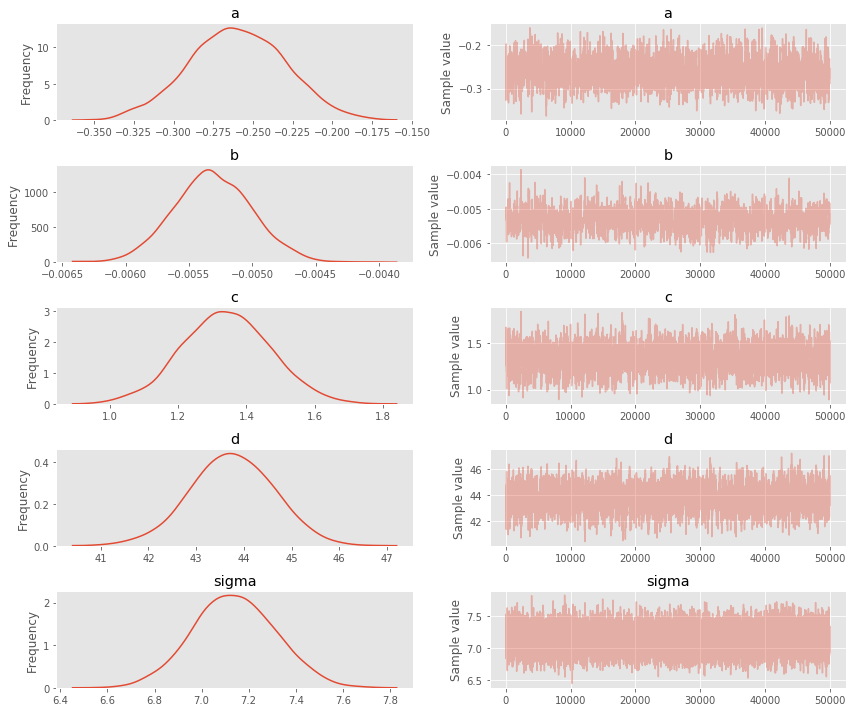

In [61]:
pm.traceplot(trace_2013)

In [21]:
a_mean_2013 = np.mean(trace_2013.get_values('a'))
a_std_2013 = np.std(trace_2013.get_values('a'))

b_mean_2013 = np.mean(trace_2013.get_values('b'))
b_std_2013 = np.std(trace_2013.get_values('b'))

c_mean_2013 = np.mean(trace_2013.get_values('c'))
c_std_2013 = np.std(trace_2013.get_values('c'))

d_mean_2013 = np.mean(trace_2013.get_values('d'))
d_std_2013 = np.std(trace_2013.get_values('d'))

Text(0.5,1,'No of Stores, beta_3')

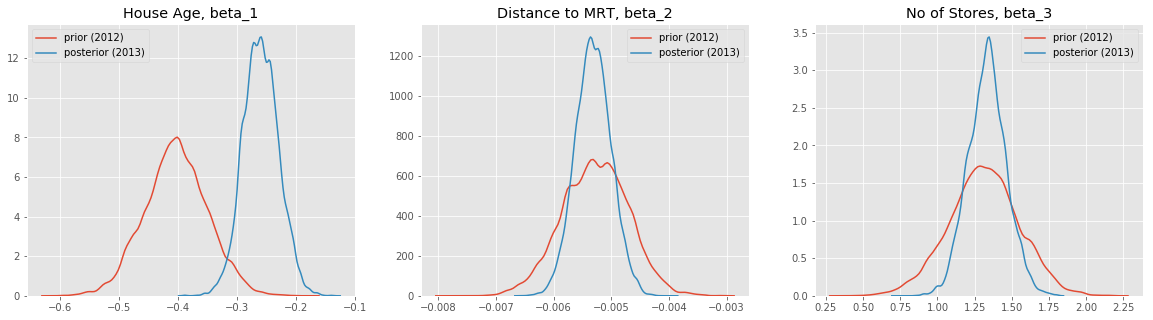

In [81]:
plt.rcParams['figure.figsize'] = [20,5]

f, axes = plt.subplots(1, 3)

sns.kdeplot(trace_2012.get_values('beta_1'), label='prior (2012)', ax=axes[0])
sns.kdeplot(trace_2013.get_values('a'), label='posterior (2013)', ax=axes[0])
axes[0].set_title('House Age, beta_1')

sns.kdeplot(trace_2012.get_values('beta_2'), label='prior (2012)', ax=axes[1])
sns.kdeplot(trace_2013.get_values('b'), label='posterior (2013)', ax=axes[1])
axes[1].set_title('Distance to MRT, beta_2')

sns.kdeplot(trace_2012.get_values('beta_3'), label='prior (2012)', ax=axes[2])
sns.kdeplot(trace_2013.get_values('c'), label='posterior (2013)', ax=axes[2])
axes[2].set_title('No of Stores, beta_3')

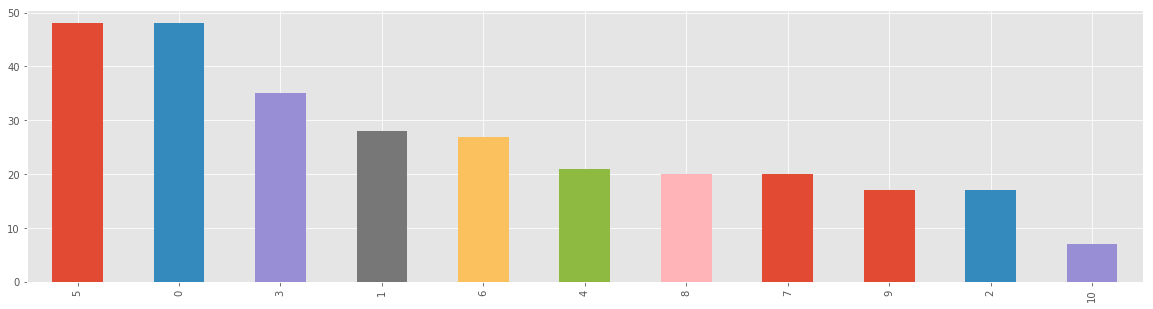

In [104]:
pd.DataFrame(x_3)[0].value_counts().plot.bar()

In [106]:
np.mean(x_3)

4.083333333333333

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


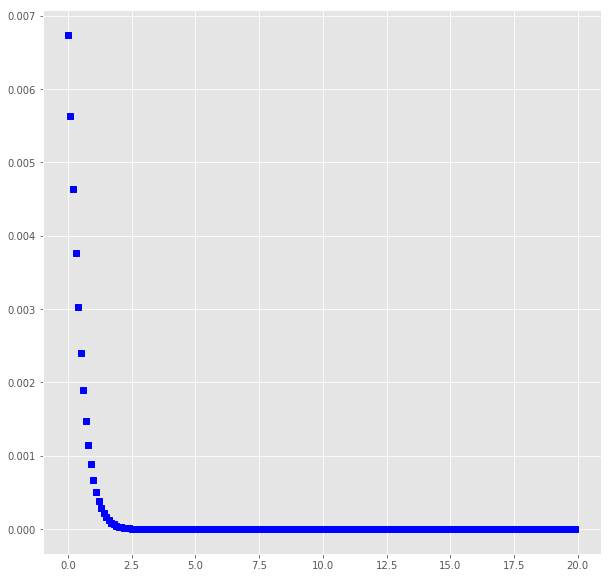

In [145]:
from scipy.misc import factorial
t = np.arange(0, 20, 0.1)
d = np.exp(-5)*np.power(np.mean(0.1), t)/factorial(t)

plt.plot(t, d, 'bs')

---

In [216]:
import matplotlib.mlab as mlab

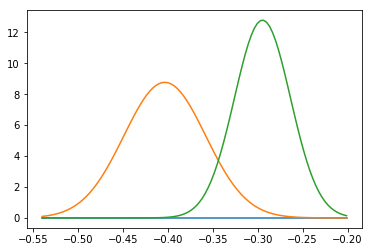

In [225]:
x = np.linspace(a_mean_2012 - 3*a_std_2012, a_mean_2013 + 3*a_std_2013, 100)
plt.plot(x, mlab.normpdf(x, 0, 100))
plt.plot(x,mlab.normpdf(x, a_mean_2012, a_std_2012))
plt.plot(x, mlab.normpdf(x, a_mean_2013, a_std_2013))

In [209]:
start_2012

{'a': array(-0.40348041),
 'b': array(-0.0053041),
 'c': array(1.29991898),
 'd': array(43.33656541),
 'sigma': array(5.74147031),
 'sigma_log__': array(1.74771533)}

In [210]:
start_2013

{'a': array(-0.28278141),
 'b': array(-0.00511995),
 'c': array(1.43785029),
 'd': array(43.31105413),
 'sigma': array(8.87299547),
 'sigma_log__': array(2.18301245)}

In [211]:
start

{'a': array(-0.25276685),
 'b': array(-0.00537762),
 'c': array(1.29816766),
 'd': array(42.97035339),
 'sigma': array(8.4957206),
 'sigma_log__': array(2.13956258)}

In [213]:
a_mean_2012, b_mean_2012, c_mean_2012, d_mean_2012

(-0.40348589013561764,
 -0.005283323797871614,
 1.306347357171707,
 43.280891582353824)

In [214]:
a_mean_2013, b_mean_2013, c_mean_2013, d_mean_2013

(-0.29473623500954965,
 -0.005269655637478248,
 1.3643169505400004,
 44.15022169955401)

In [215]:
a_mean, b_mean, c_mean, d_mean

(-0.25408293397510934,
 -0.005400668022587039,
 1.2980323797833249,
 43.02922574596292)

In [196]:
sklr_2012=LinearRegression()
sklr_2012.fit(df_2012[[i for i in df.columns if i not in ['price_per_area']]],df_2012['price_per_area'])
sklr_2012.coef_ , sklr_2012.intercept_

(array([-0.40360515, -0.00530611,  1.29893949]), 43.34601463091228)

In [197]:
sklr_2013=LinearRegression()
sklr_2013.fit(df_2013[[i for i in df.columns if i not in ['price_per_area']]],df_2013['price_per_area'])
sklr_2013.coef_ , sklr_2013.intercept_

(array([-0.19289955, -0.00539093,  1.29986538]), 42.81094345824692)

In [198]:
sklr=LinearRegression()
sklr.fit(df[[i for i in df.columns if i not in ['price_per_area']]],df['price_per_area'])
sklr.coef_ , sklr.intercept_

(array([-0.25285583, -0.00537913,  1.29744248]), 42.9772862060641)